In [1]:
# TimeSeries generation of sin(x) function. Basically given the values of sin(x) upto t, the RNN should be able to generate
# the sequence upto t+1

In [33]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class TimeSeriesData():
    """
    TimeSeriesData here is simply a class that can generate data of sin function. 
    When we create an instance of this class we are going to provide the num_points and the xmin and xmax values
    """
    def __init__(self, num_points, x_min, x_max):
        """
        The initialization step involves creating a few more variables like
        
        resolution that defines how close the points should be to one another. Since this is going to generate a 
        TimeSeries resolution defines the literal resolution of the points
        
        x_data which are the equally spaced points from xmin to xmax 
        y_true will be the original sin wave corresponding to x_data
        """
        self.x_min = x_min
        self.x_max = x_max
        self.num_points = num_points
        self.resolution = (x_max - x_min)/num_points
        self.x_data = np.linspace(x_min, x_max, num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        
        # Grab a random starting point for each batch of the data
        rand_start = np.random.rand(batch_size, 1) # this will give a column vector of dim: batch_size X 1
#         print(rand_start)
        
        # Convert to be on time series
        ts_start = rand_start * (self.x_max - self.x_min - (steps * self.resolution))
#         print(ts_start)
        
        # Create batch time series on the X data
        batch_ts = ts_start + np.arange(0.0, steps + 1) * self.resolution
#         print(batch_ts)
        
        # Create the y data for the time series x axis from the previous step
        y_batch = np.sin(batch_ts)
#         print(y_batch)
        
        # Formatting for RNN
        if return_batch_ts:
            # Here note that the first value being returned is the time series itself and
            # the second value being returned is the time series shifted by one step
            return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:,1:].reshape(-1, steps, 1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:,1:].reshape(-1, steps, 1)

In [4]:
ts_data = TimeSeriesData(250,0,10)

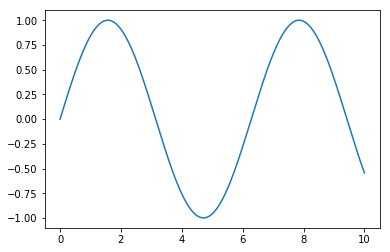

In [5]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [6]:
num_time_steps = 30 # number of time steps in one batch

In [7]:
y1,y2,ts = ts_data.next_batch(batch_size=1, steps=30, return_batch_ts=True) # basically give me back one batch of 30 samples

In [8]:
 ts.flatten()

array([7.00154241, 7.04154241, 7.08154241, 7.12154241, 7.16154241,
       7.20154241, 7.24154241, 7.28154241, 7.32154241, 7.36154241,
       7.40154241, 7.44154241, 7.48154241, 7.52154241, 7.56154241,
       7.60154241, 7.64154241, 7.68154241, 7.72154241, 7.76154241,
       7.80154241, 7.84154241, 7.88154241, 7.92154241, 7.96154241,
       8.00154241, 8.04154241, 8.08154241, 8.12154241, 8.16154241,
       8.20154241])

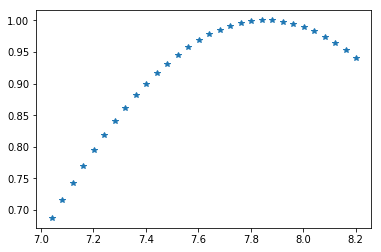

In [9]:
plt.plot(ts.flatten()[1:], y2.flatten(), '*') # remember batch_ts or ts here has 31 steps

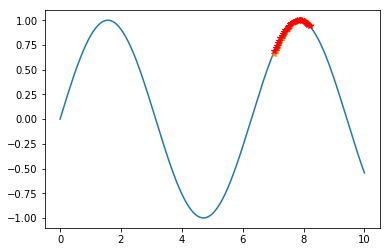

In [10]:
plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:], y1.flatten(), '*', label="Single Training instance shifted by one")
plt.plot(ts.flatten()[1:], y2.flatten(), 'r*', label="Single Training instance")

In [11]:
train_inst = np.linspace(5, 5 + ts_data.resolution * (num_time_steps + 1), num_time_steps + 1)

In [12]:
train_inst

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

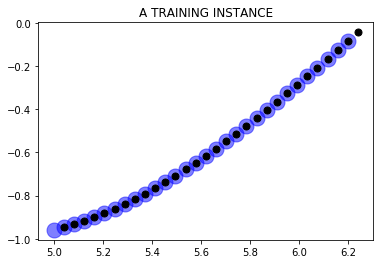

In [13]:
plt.title('A TRAINING INSTANCE')
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label="INSTANCE")
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), 'ko', markersize=7, label='TARGET')

In [14]:
num_inputs = 1 # obviously we are feeding in only one data at a time

In [15]:
num_neurons = 100

In [16]:
num_outputs = 1

In [17]:
learning_rate = 0.0001

In [18]:
num_train_iterations = 2000

In [19]:
batch_size = 1

In [20]:
# PLACEHOLDERS
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])

In [21]:
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [22]:
# RNN Cell Layer

In [23]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu)
# here remember that we only require one output however we are using 100 neurons, so in order to have only one output
# from these 100 neurons we would use a OutputProjectionWrapper
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=num_outputs)

Instructions for updating:
Use the retry module or similar alternatives.


In [24]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [25]:
# finally we would need a loss function and an optimizer

In [26]:
# MEAN SQUARED ERROR as loss function
loss = tf.reduce_mean(tf.square(outputs-y))

In [27]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [28]:
train = optimizer.minimize(loss)

In [29]:
init = tf.global_variables_initializer()

In [30]:
# SESSION

In [31]:
saver = tf.train.Saver() # this simply allows me to save my model

In [32]:
with tf.Session() as sess: # this is obviosuly the training phase, as you could see here 
    sess.run(init)
    for iteration in range(num_train_iterations):
        X_batch, y_batch = ts_data.next_batch(batch_size=batch_size, steps=num_time_steps)
        sess.run(train, feed_dict={X:X_batch, y:y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X:X_batch, y:y_batch})
            print(iteration, "\tMSE", mse)
            
        saver.save(sess, "./rnn_time_series_model_sin_timeseries")

0 	MSE 0.7018919
100 	MSE 0.26261777
200 	MSE 0.020826455
300 	MSE 0.02161192
400 	MSE 0.023107413
500 	MSE 0.0018820777
600 	MSE 0.011073923
700 	MSE 0.018019726
800 	MSE 0.0013283378
900 	MSE 0.0058432324
1000 	MSE 0.00047826295
1100 	MSE 0.013456751
1200 	MSE 0.01556621
1300 	MSE 0.0010926073
1400 	MSE 0.0012249487
1500 	MSE 0.00781446
1600 	MSE 0.0014339543
1700 	MSE 0.0057246867
1800 	MSE 0.0029333434
1900 	MSE 0.01026277


In [ ]:
# Note that we can actually directly change the rnn cell from basicrnn to gru cells and we do not need to change anything 
# else. 